In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
# Paths to your local dataset
base_dir = 'D:/Rice Leaf Diseases Dataset'

In [3]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

In [4]:
# Data augmentation with additional techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6946 images belonging to 4 classes.
Found 1735 images belonging to 4 classes.


In [5]:
# Compute class weights to handle class imbalance
class_labels = train_generator.class_indices
class_weights = compute_class_weight('balanced', classes=np.arange(len(class_labels)), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
# Load the ResNet50 model with pre-trained weights, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)  # Increased dropout rate
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [8]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [10]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weights_dict
)

Epoch 1/20
218/218 [==============================] - 540s 2s/step - loss: 0.9167 - accuracy: 0.6402 - val_loss: 2.0185 - val_accuracy: 0.2432 - lr: 1.0000e-05
Epoch 2/20
218/218 [==============================] - 505s 2s/step - loss: 0.4002 - accuracy: 0.8601 - val_loss: 1.6789 - val_accuracy: 0.3043 - lr: 1.0000e-05
Epoch 3/20
218/218 [==============================] - 633s 3s/step - loss: 0.2359 - accuracy: 0.9207 - val_loss: 1.4528 - val_accuracy: 0.4939 - lr: 1.0000e-05
Epoch 4/20
218/218 [==============================] - 803s 4s/step - loss: 0.1613 - accuracy: 0.9463 - val_loss: 1.3352 - val_accuracy: 0.6357 - lr: 1.0000e-05
Epoch 5/20
218/218 [==============================] - 642s 3s/step - loss: 0.1197 - accuracy: 0.9634 - val_loss: 1.3160 - val_accuracy: 0.7631 - lr: 1.0000e-05
Epoch 6/20
218/218 [==============================] - 532s 2s/step - loss: 0.0915 - accuracy: 0.9699 - val_loss: 1.3411 - val_accuracy: 0.7798 - lr: 1.0000e-05
Epoch 7/20
218/218 [====================

In [15]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

55/55 [==============================] - 152s 3s/step - loss: 1.3020 - accuracy: 0.7620
Validation accuracy: 0.76


In [16]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

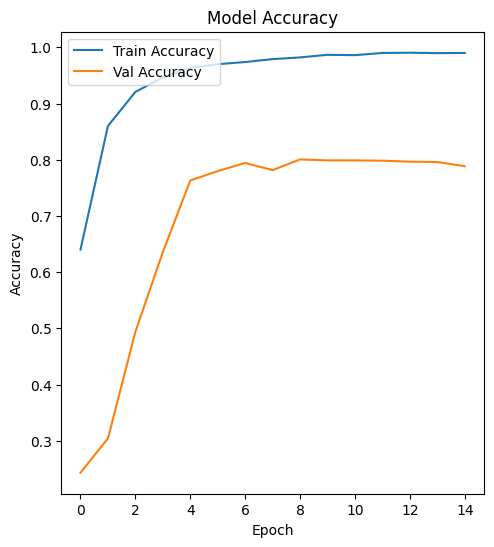

In [17]:
# Assuming 'history' is the result of model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

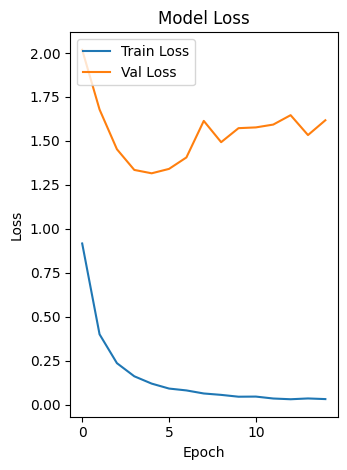

In [18]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

1/1 [==============================] - 3s 3s/step
True Label: Bacterial Leaf Blight, Predicted Label: Bacterial Leaf Blight


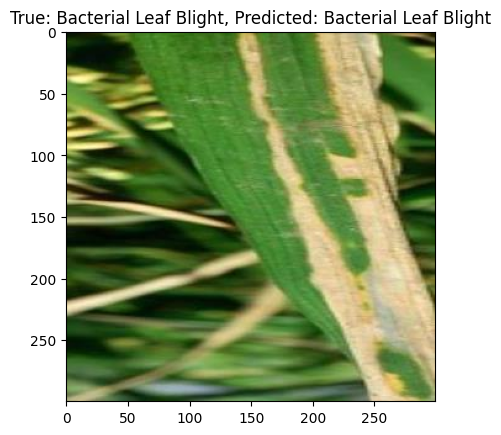

1/1 [==============================] - 0s 140ms/step
True Label: Brown Spot, Predicted Label: Brown Spot


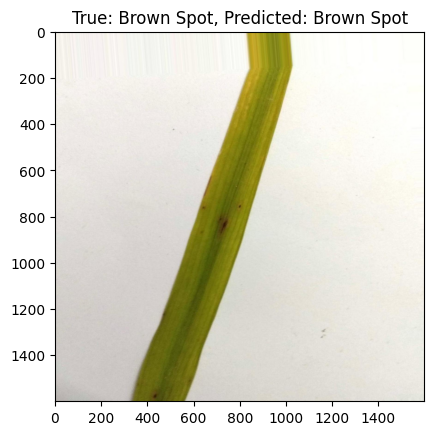

1/1 [==============================] - 0s 45ms/step
True Label: Healthy, Predicted Label: Healthy


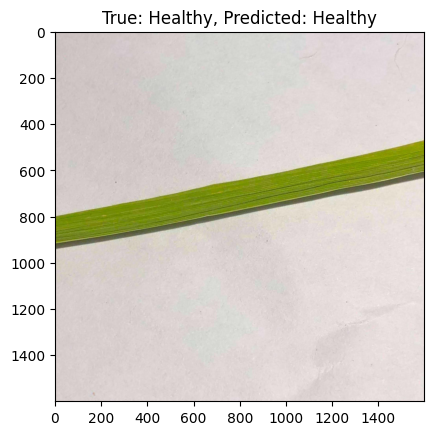

1/1 [==============================] - 0s 47ms/step
True Label: Leaf Blast, Predicted Label: Leaf Blast


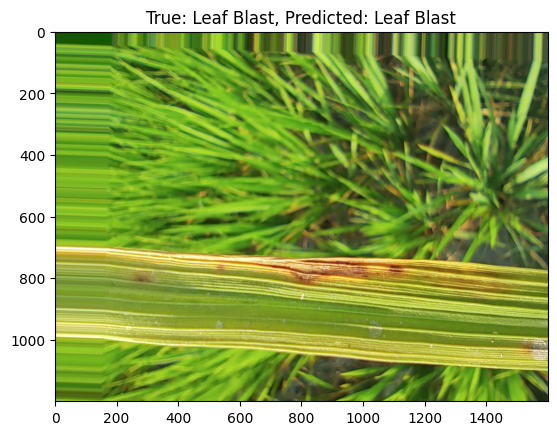

In [21]:
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define the class labels (these should match your dataset)
class_labels = train_generator.class_indices
label_map = {v: k for k, v in class_labels.items()}  # Invert the mapping to get the class names by index

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, img_height=224, img_width=224):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale to [0, 1] range
    return img_array

# Randomly select one image from each class
random_images = {}
for label in class_labels:
    label_dir = os.path.join(base_dir, label)  # Path to the folder of each label
    image_files = os.listdir(label_dir)
    random_image = random.choice(image_files)  # Randomly select one image
    random_images[label] = os.path.join(label_dir, random_image)

# Load and predict the label for each random image
for label, img_path in random_images.items():
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = label_map[predicted_class]
    
    print(f"True Label: {label}, Predicted Label: {predicted_label}")
    
    # Optionally display the image and prediction
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"True: {label}, Predicted: {predicted_label}")
    plt.show()


In [22]:
# Save the model in the native Keras format
model.save('soyabean_densenet121_model_improved.keras')